Aggregated Results Across Models:

SGD:
Accuracy: 0.9651
Precision: 0.9793
Recall: 0.9528
F1: 0.9657

LogReg:
Accuracy: 0.9565
Precision: 0.9730
Recall: 0.9420
F1: 0.9572

RF:
Accuracy: 0.9887
Precision: 0.9892
Recall: 0.9889
F1: 0.9890

GB:
Accuracy: 0.9835
Precision: 0.9845
Recall: 0.9837
F1: 0.9841


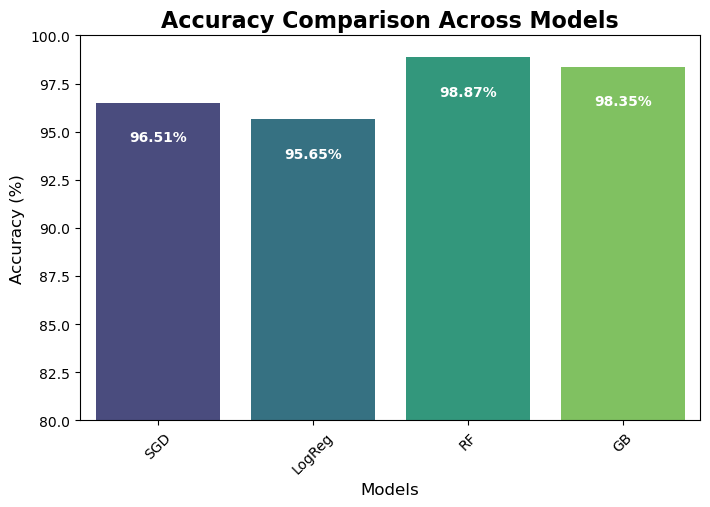

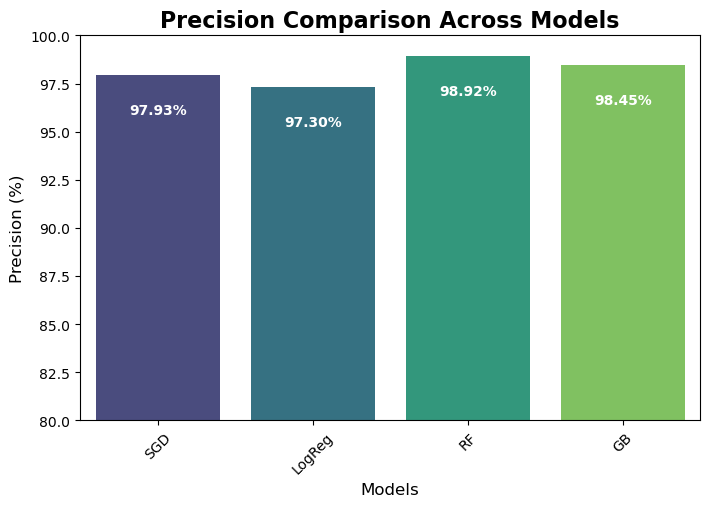

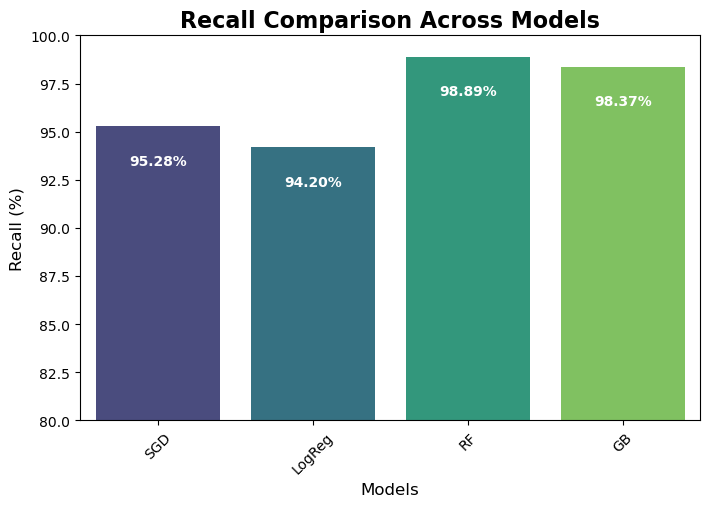

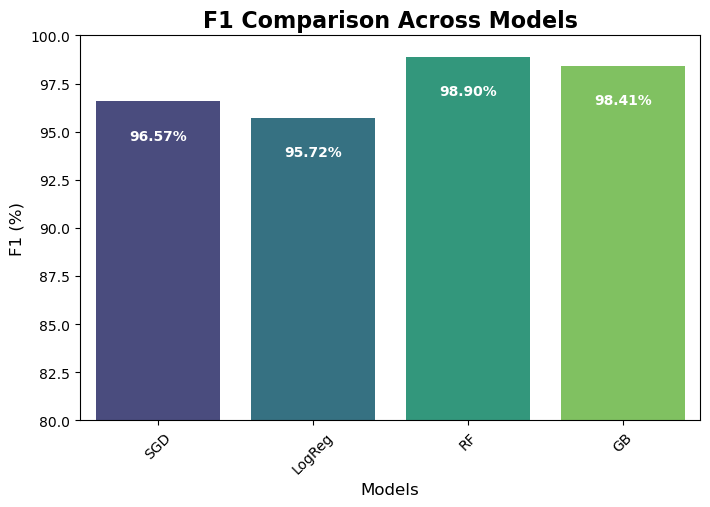

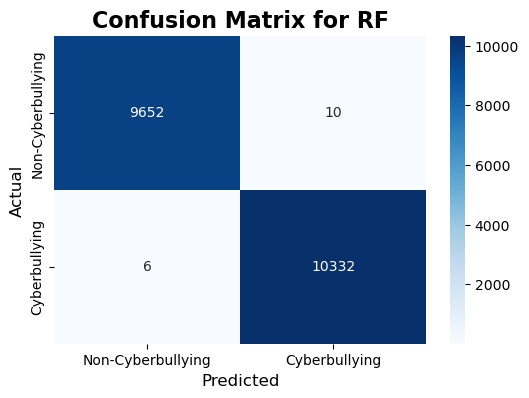

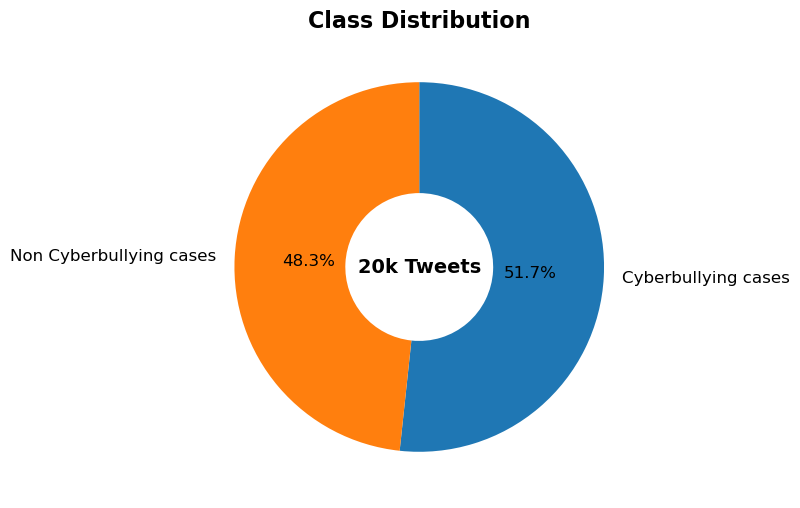

In [5]:
#=============================== IMPORT PACKAGES ===========================
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import warnings
warnings.filterwarnings("ignore")

#===================== 1. READ INPUT DATA ================================
data = pd.read_csv(r'C:/Users/vudit/OneDrive/Desktop/Data Science/Projects/Classification for Cyber bully detection on Social media/Cyberbullying_dataset.csv')
data = data.sample(20000, random_state=42)  # Sample for consistency

#=====================  2. DATA PREPROCESSING =============================
# Drop unwanted columns
if 'annotation' in data.columns:
    data = data.drop(['annotation'], axis=1)

# Text cleaning
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    return sentence

data["Summary_Clean"] = data["content"].apply(cleanup)

#=================== 3. SENTIMENT ANALYSIS ====================
analyzer = SentimentIntensityAnalyzer()

# Handle missing values and calculate sentiment scores
data['Summary_Clean'] = data['Summary_Clean'].fillna('')  # Replace NaN with an empty string
data['compound'] = data['Summary_Clean'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
data['neg'] = data['Summary_Clean'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
data['neu'] = data['Summary_Clean'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
data['pos'] = data['Summary_Clean'].apply(lambda x: analyzer.polarity_scores(x)['pos'])

# Define labels using compound score
data['true_label'] = data['compound'].apply(lambda c: 0 if c >= 0 else 1)

#=================== 4. FEATURE REPRESENTATION ============================
# Use sentiment scores as features
sentiment_features = ['neg', 'neu', 'pos']
X_sentiment = data[sentiment_features]
Y = data['true_label']

#=================== 5. CROSS-VALIDATION WITH MULTIPLE MODELS ====================
# Initialize models
models = {
    "SGD": SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, class_weight='balanced'),
    "LogReg": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=50),
    "RF": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=50),
    "GB": GradientBoostingClassifier(random_state=50)
}

# Initialize metrics tracking
results = {model_name: {"accuracy": [], "precision": [], "recall": [], "f1": []} for model_name in models}

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
for train_idx, test_idx in skf.split(X_sentiment, Y):
    X_train, X_test = X_sentiment.iloc[train_idx], X_sentiment.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    for model_name, model in models.items():
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        results[model_name]["accuracy"].append(accuracy_score(Y_test, preds))
        results[model_name]["precision"].append(precision_score(Y_test, preds, pos_label=1))
        results[model_name]["recall"].append(recall_score(Y_test, preds, pos_label=1))
        results[model_name]["f1"].append(f1_score(Y_test, preds, pos_label=1))

# Aggregate results
final_results = {model_name: {metric: sum(values) / len(values) for metric, values in metrics.items()} for model_name, metrics in results.items()}

# Print aggregated results
print("Aggregated Results Across Models:")
for model_name, metrics in final_results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

#===================== 6. VISUALIZATION ================================
# Bar chart for model comparison
metrics_to_plot = ["accuracy", "precision", "recall", "f1"]
model_names = list(final_results.keys())
bar_data = {metric: [final_results[model][metric] * 100 for model in model_names] for metric in metrics_to_plot}

for metric, values in bar_data.items():
    plt.figure(figsize=(8, 5))
    bars = sns.barplot(x=model_names, y=values, palette="viridis")
    plt.title(f"{metric.capitalize()} Comparison Across Models", fontsize=16, fontweight='bold')
    plt.ylabel(f"{metric.capitalize()} (%)", fontsize=12)
    plt.xlabel("Models", fontsize=12)
    plt.ylim(80, 100)
    plt.xticks(rotation=45)
    for bar, value in zip(bars.patches, values):
        bars.annotate(f"{value:.2f}%", (bar.get_x() + bar.get_width() / 2, bar.get_height() - 2), ha='center', color='white', fontsize=10, fontweight='bold')
    plt.show()

# Confusion Matrix for Best Model (e.g., Random Forest)
best_model_name = max(final_results, key=lambda x: final_results[x]["f1"])  # Select model with highest F1-score
best_model = models[best_model_name]
best_model.fit(X_sentiment, Y)
preds = best_model.predict(X_sentiment)
conf_matrix = confusion_matrix(Y, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Cyberbullying", "Cyberbullying"], yticklabels=["Non-Cyberbullying", "Cyberbullying"])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16, fontweight='bold')
plt.show()

# Class Distribution
data['comp_score'] = data['true_label'].replace([1, 0], ["Cyberbullying cases", "Non Cyberbullying cases"])
plt.figure(figsize=(6, 6))
counts = data['comp_score'].value_counts()
plt.pie(counts, labels=counts.index, startangle=90, counterclock=False, wedgeprops={'width': 0.6}, autopct='%1.1f%%', textprops={'fontsize': 12})
plt.text(0, 0, '20k Tweets', ha='center', va='center', fontsize=14, fontweight='bold')
plt.title('Class Distribution', fontsize=16, fontweight='bold')
plt.show()
